# CCC GARCH

## Data processing

In [4]:
import os
from utils import Portfolio
import pandas as pd
import numpy as np

os.chdir('C:/Users/howar/Desktop/Coursework/ME4-Individual-Project-Volatility-Forecasting')
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.1.2'

In [5]:
r = pd.read_csv(os.path.join(fpath, 'data/daily_returns.csv'), index_col=0, parse_dates=True)
intraday = pd.read_csv(os.path.join(fpath, 'data/intraday_returns.csv'), index_col=0, parse_dates=True)

# Match dates
r = r[r.index.isin(np.unique(intraday.index.date))]

## Define and run model

In [8]:
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro 
from tqdm.notebook import trange

window = 252
forecast_dates = []
covariance =  []

for i in trange(len(r) - window):
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_rets = ro.conversion.py2rpy(r.iloc[i:i + window])
        
    forecast_dates.append(r.index[i + window])

    r_ccc_code = """
        library('rmgarch')

        function(r_rets, n_days){
            univariate_spec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                                          variance.model = list(garchOrder = c(1,1),
                                                                variance.targeting = FALSE, 
                                                                model = "sGARCH"),
                                          distribution.model = "norm")
            n <- dim(r_rets)[2]

            ccc_spec <- cgarchspec(uspec = multispec(replicate(n, univariate_spec)),
                                   dccOrder = c(1,1),
                                   distribution = list("mvnorm"))

            ccc_fit <- cgarchfit(ccc_spec, r_rets)
            forecast <- cgarchsim(ccc_fit, n.sim = n_days)

            return(rcov(forecast))
        }
    """

    r_cccgarch = ro.r(r_ccc_code)
    covariance.append(np.array(r_cccgarch(r_rets, 1)).T)

  0%|          | 0/2013 [00:00<?, ?it/s]

NameError: name 'cov' is not defined

In [9]:
covariance = np.array(covariance)
covariance = np.squeeze(covariance, axis=1)
covariance.shape

(2013, 12, 12)

# Portfolio optimization

Final Portfolio Value: $124.2
Overall Return (%): 24.19
Sharpe Ratio: 1.66
Sortino Ratio: 2.28


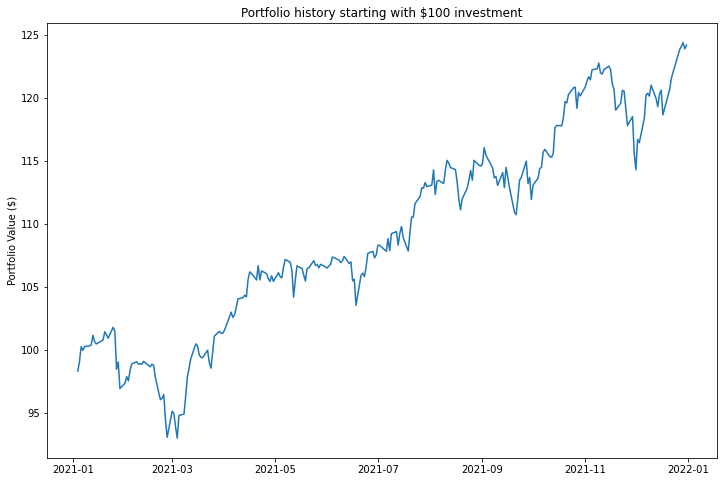

In [11]:
r_test = pd.read_csv('data/daily_returns_test.csv', index_col=0, parse_dates=True)
test_window = len(r_test)

ccc_port = Portfolio(r_test, covariance[-test_window:])
ccc_returns = ccc_port.optimize(return_percent=True)

# Optimization results
ccc_port.metrics(starting_value=100, print_metrics=True, plot_history=True)

In [13]:
np.save('outputs/CCC/ccc_covariance.npy', covariance)
ccc_port.weights.to_csv('outputs/CCC/ccc_portfolio_weights.csv', index=True)

In [19]:
from utils import compute_covariance

# Also interested in computing the MSE
cov_pred = covariance[-test_window:]
cov_true = compute_covariance(intraday[np.isin(intraday.index.date, r_test.index.date)]).values.reshape((-1, 12, 12))

In [20]:
mse = np.mean(np.square(cov_true - cov_pred))
mse

1.696877777110007e-08